In [2]:
import os, sys
from ruamel.yaml import YAML
import numpy as np
import pandas as pd
import math
from typing import Dict, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from einops import rearrange
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.transforms import RandomRotation
from torch.utils.data import TensorDataset, DataLoader, random_split
from src.models_multimodal import (
    ConvMixer,
    TransformerWithTimeEmbeddings,
    LightCurveImageCLIP,
)
from src.utils import (
    get_valid_dir,
    LossTrackingCallback,
    plot_loss_history,
    get_embs,
    find_indices_in_arrays,
    get_AUC,
    LossTrackingCallback,
    cosine_similarity,
    plot_ROC_curves,
    get_ROC_data,
)
from src.dataloader import (
    load_images,
    load_lightcurves,
    plot_lightcurve_and_images,
    load_spectras,
    load_data,
    NoisyDataLoader,
)
from src.loss import sigmoid_loss, clip_loss
from typing import Tuple
from src.transformer_utils import Transformer

from IPython.display import Image as IPImage

device = "cuda" if torch.cuda.is_available() else "cpu"

%load_ext autoreload
%autoreload 2

### Loading SLSN-I supernovae

In [7]:
data_dirs = [
    "./data/ZTFBTS/",
    "/home/thelfer1/scr4_tedwar42/thelfer1/ZTFBTS/",
    "ZTFBTS/",
    "/ocean/projects/phy230064p/shared/ZTFBTS/",
    "/n/home02/gemzhang/repos/Multimodal-hackathon-2024/data/ZTFBTS/",
]

# Get the first valid directory
data_dir = get_valid_dir(data_dirs)

In [8]:
data_dir

'/home/thelfer1/scr4_tedwar42/thelfer1/ZTFBTS/'

In [9]:
# load the filenames of SLSN-I supernovae
df = pd.read_csv(f"{data_dir}ZTFBTS_TransientTable.csv")
filenames_SLSNI = df[df["type"] == "SLSN-I"]["ZTFID"].to_list()[0:1]

In [10]:
filenames = df["ZTFID"].to_list()

In [11]:
# load the data for SLSN-I supernovae and all of the images
ims_SLSNI, _ = load_images(f"{data_dir}", filenames_SLSNI)
ims, ims_names = load_images(f"{data_dir}")
time_ary, mag_ary, magerr_ary, mask_ary, _, lc_names = load_lightcurves(f"{data_dir}")

# freq_ary_SLSNI, spec_ary_SLSNI, specerr_ary_SLSNI, specmask_ary_SLSNI, spec_names_SLSNI = load_spectras("./data/ZTFBTS_spectra/",
#                                                                                                    filenames=filenames_SLSNI)
(
    time_ary_SLSNI,
    mag_ary_SLSNI,
    magerr_ary_SLSNI,
    mask_ary_SLSNI,
    _,
    lc_names_SLSNI,
) = load_lightcurves(f"{data_dir}", filenames=filenames_SLSNI)

Loading images...


100%|██████████| 1/1 [00:00<00:00, 37.44it/s]


Loading images...


100%|██████████| 5171/5171 [00:36<00:00, 143.00it/s]


Loading light curves...


100%|██████████| 5170/5170 [00:22<00:00, 229.28it/s]


Loading light curves...


100%|██████████| 1/1 [00:00<00:00, 308.59it/s]


### Setting up model from checkpoint

In [16]:
# load a trained model and its config
path = "./models/lightcurve-galaxy/ethereal-sweep-4/epoch=493-step=76076.ckpt"
cfg = YAML(typ="safe").load(open(f"{os.path.dirname(path)}/config.yaml"))
print(cfg)

# Setting parameters for models
transformer_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm"],
}

transformer_spectral_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb_spectral"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth_spectral"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm_spectral"],
}

conv_kwargs = {
    "dim": 32,
    "depth": cfg["cnn_depth"],
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": cfg["n_out"],
    "dropout_prob": cfg["dropout"],
}

model = LightCurveImageCLIP(
    logit_scale=cfg["logit_scale"],
    lr=cfg["lr"],
    nband=2,
    loss="softmax",
    transformer_kwargs=transformer_kwargs,
    transformer_spectral_kwargs=transformer_spectral_kwargs,
    conv_kwargs=conv_kwargs,
    optimizer_kwargs={},
    combinations=["host_galaxy", "lightcurve"],
)

model.load_state_dict(torch.load(path, map_location=torch.device(device))["state_dict"])

{'agg': 'mean', 'agg_spectral': 'mean', 'batchsize': 32, 'cnn_depth': 7, 'dropout': 0.0072484609941876, 'emb': 64, 'emb_spectral': 32, 'epochs': 500, 'heads': 8, 'heads_spectral': 8, 'logit_scale': 8.471890237718537, 'lr': 2.481529679233978e-05, 'n_out': 32, 'seed': 0, 'time_norm': 363.0794848503694, 'time_norm_spectral': 7405.896275312251, 'transformer_depth': 16, 'transformer_depth_spectral': 2, 'weight_decay': 7.287157067362061e-05}


<All keys matched successfully>

In [17]:
# load a trained trimodal model and its config
path = "./models/trimodal/prime-sweep-81/epoch=287-step=43200.ckpt"
cfg = YAML(typ="safe").load(open(f"{os.path.dirname(path)}/config.yaml"))
print(cfg)

transformer_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm"],
    "agg": cfg["agg"],
}

transformer_spectral_kwargs = {
    "n_out": cfg["n_out"],
    "emb": cfg["emb_spectral"],
    "heads": cfg["heads"],
    "depth": cfg["transformer_depth_spectral"],
    "dropout": cfg["dropout"],
    "time_norm": cfg["time_norm_spectral"],
    "agg": cfg["agg_spectral"],
}

conv_kwargs = {
    "dim": 32,
    "depth": cfg["cnn_depth"],
    "channels": 3,
    "kernel_size": 5,
    "patch_size": 10,
    "n_out": cfg["n_out"],
    "dropout_prob": cfg["dropout"],
}

model_tri = LightCurveImageCLIP(
    logit_scale=cfg["logit_scale"],
    lr=cfg["lr"],
    nband=2,
    loss="softmax",
    transformer_kwargs=transformer_kwargs,
    transformer_spectral_kwargs=transformer_spectral_kwargs,
    conv_kwargs=conv_kwargs,
    optimizer_kwargs={},
    combinations=["host_galaxy", "lightcurve", "spectral"],
)
# load weights
model_tri.load_state_dict(
    torch.load(path, map_location=torch.device(device))["state_dict"]
)

# load spectral embedding
# sp_emb_SLSNI = model_tri.spectral_embeddings_with_projection(torch.from_numpy(spec_ary_SLSNI).to(torch.float32),
#                                                     torch.from_numpy(freq_ary_SLSNI).to(torch.float32),
#                                                     torch.from_numpy(specmask_ary_SLSNI).to(torch.bool))

{'agg': 'mean', 'agg_spectral': 'mean', 'batchsize': 32, 'cnn_depth': 5, 'dropout': 0.009971398925813077, 'emb': 64, 'emb_spectral': 64, 'epochs': 800, 'heads': 4, 'heads_spectral': 8, 'logit_scale': 17.415645235447595, 'lr': 6.484310725110905e-05, 'n_out': 32, 'seed': 0, 'time_norm': 7176.357302735578, 'time_norm_spectral': 9124.730024216396, 'transformer_depth': 3, 'transformer_depth_spectral': 15, 'weight_decay': 1.0795800085560923e-05}


<All keys matched successfully>

### Calculate embeddings 

In [18]:
# get embeddings of all images and the first lightcurve in filenames_SLSNI
ims_emb_SLSNI = model.image_embeddings_with_projection(ims_SLSNI)
lc_emb_SLSNI = model.lightcurve_embeddings_with_projection(
    torch.from_numpy(mag_ary_SLSNI).to(torch.float32),
    torch.from_numpy(time_ary_SLSNI).to(torch.float32),
    torch.from_numpy(mask_ary_SLSNI).to(torch.bool),
)

In [ ]:
ims_emb = model.image_embeddings_with_projection(ims)
lc_emb = model.lightcurve_embeddings_with_projection(
    torch.from_numpy(mag_ary).to(torch.float32),
    torch.from_numpy(time_ary).to(torch.float32),
    torch.from_numpy(mask_ary).to(torch.bool),
)

In [9]:
SN_types = [df.loc[df["ZTFID"] == x, "type"].values[0] for x in lc_names]

In [10]:
# get their cosine similarity
cos_sim_lc = cosine_similarity(lc_emb, lc_emb_SLSNI)

In [11]:
cos_sim_im = cosine_similarity(ims_emb, ims_emb_SLSNI)

In [12]:
joint_emb = torch.cat((ims_emb, lc_emb), 1)
joint_emb_SLSNI = torch.cat((ims_emb_SLSNI, lc_emb_SLSNI), 1)

In [13]:
cos_sim_joint = cosine_similarity(joint_emb, joint_emb_SLSNI)

In [14]:
np.unique(SN_types)

array(['Ca-rich', 'ILRT', 'LBV', 'LRN', 'SLSN-I', 'SLSN-II', 'SN II',
       'SN II-pec', 'SN IIP', 'SN IIb', 'SN IIn', 'SN Ia', 'SN Ia-91T',
       'SN Ia-91bg', 'SN Ia-CSM', 'SN Ia-SC', 'SN Ia-pec', 'SN Iax',
       'SN Ib', 'SN Ib-pec', 'SN Ib/c', 'SN Ibn', 'SN Ic', 'SN Ic-BL',
       'SN Ic-pec', 'SN Icn', 'TDE', 'other'], dtype='<U10')

In [15]:
SLSN_bool = np.array([False] * len(SN_types))
SN_types = np.array(SN_types)
longlived_bool = np.array([False] * len(SN_types))

In [16]:
SLSN_bool = (SN_types == "SLSN-I") | (SN_types == "SLSN-II")

longlived_bool = (
    (SN_types == "SN IIn")
    | (SN_types == "TDE")
    | (SN_types == "SLSN-I")
    | (SN_types == "SLSN-II")
    | (SN_types == "SN IIP")
)

In [18]:
from collections import Counter

Counter(SN_types[cos_sim_joint.detach() > 0.9])

Counter({'SN Ia': 546,
         'SN II': 86,
         'SN IIn': 28,
         'SN Ia-91T': 25,
         'TDE': 9,
         'SN IIb': 8,
         'SLSN-I': 5,
         'SLSN-II': 5,
         'SN IIP': 4,
         'SN Ic-BL': 3,
         'SN Ibn': 3,
         'SN Ib': 2,
         'SN Ic': 2,
         'SN Ia-pec': 2,
         'SN Ia-SC': 2,
         'SN II-pec': 1,
         'SN Ia-CSM': 1,
         'SN Ib/c': 1,
         'SN Icn': 1})

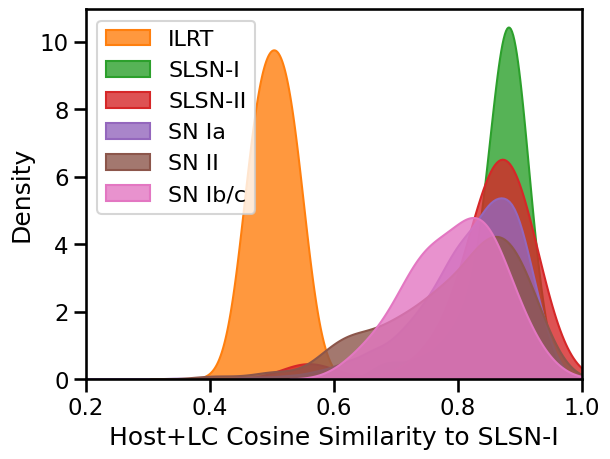

In [19]:
sns.set_context("talk")
for tempType in ["Ca-Rich", "ILRT", "SLSN-I", "SLSN-II", "SN Ia", "SN II", "SN Ib/c"]:
    sns.kdeplot(
        cos_sim_joint.detach()[SN_types == tempType],
        alpha=0.8,
        label=tempType,
        fill=True,
    )
plt.legend(loc="upper left", fontsize=16)
plt.xlabel("Host+LC Cosine Similarity to SLSN-I")
plt.xlim((0.2, 1));

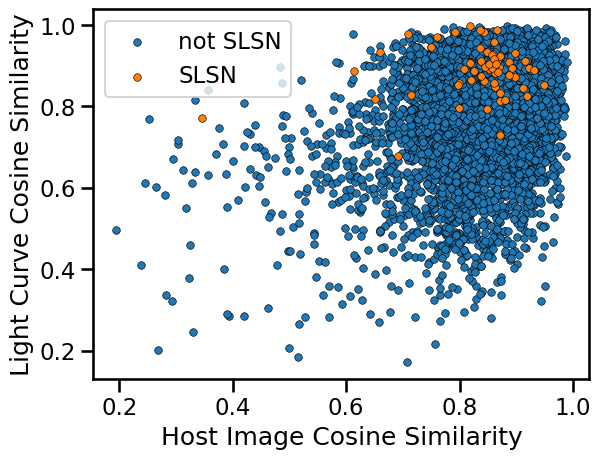

In [20]:
sns.scatterplot(
    x=cos_sim_im.detach()[~SLSN_bool],
    y=cos_sim_lc.detach()[~SLSN_bool],
    marker="o",
    s=30,
    ec="k",
    legend=False,
    label="not SLSN",
)
sns.scatterplot(
    x=cos_sim_im.detach()[SLSN_bool],
    y=cos_sim_lc.detach()[SLSN_bool],
    marker="o",
    s=30,
    ec="k",
    legend=False,
    label="SLSN",
)
plt.xlabel("Host Image Cosine Similarity")
plt.ylabel("Light Curve Cosine Similarity")
plt.legend()

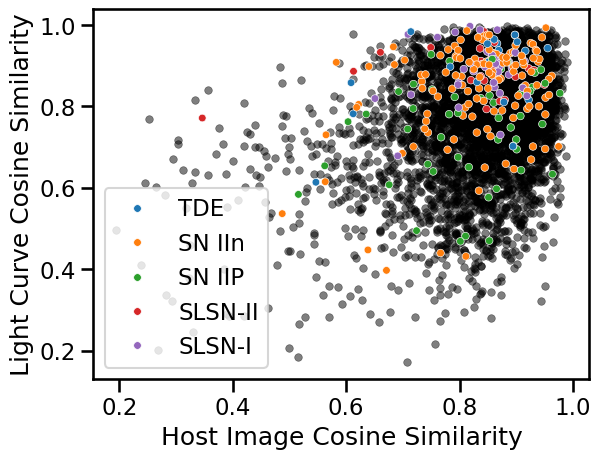

In [21]:
sns.scatterplot(
    x=cos_sim_im.detach()[~longlived_bool],
    y=cos_sim_lc.detach()[~longlived_bool],
    marker="o",
    s=30,
    ec="k",
    c="k",
    legend=False,
    alpha=0.5,
)
sns.scatterplot(
    x=cos_sim_im.detach()[longlived_bool],
    y=cos_sim_lc.detach()[longlived_bool],
    hue=SN_types[longlived_bool],
    marker="o",
    s=30,
    legend=True,
)
plt.xlabel("Host Image Cosine Similarity")
plt.ylabel("Light Curve Cosine Similarity");